# Welcome to my third Project! Web Scrapping

I'll be importing all useful libraries for my code below

In [178]:
import requests
import time
from bs4 import BeautifulSoup
from tswift import Artist, Song
import random
import nltk
from nltk import *
import numpy as np
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

For my third project, I decided to scrap the top rap songs from 1989 - 2016 from the billboard website. I want to analyze the rhetoric and see if there has been any changes from rap music in the late 90s to now. Obviously the data from the billboard website will be a little skewed (mainstream music) but its a great point to start in analyzing rap's music rhetoric. 

The purpose of the function below is to scrap the billboard website and obtain all the top rap songs from 1989 to 2016. It stores the artist and songs in a dictionary, whose keys are the year the songs made the billboards. The function will return a tuple of dictionaries containing the song titles and the artist names.  

In [179]:
#Purpose of function:
#scrap billboard websites from 1989 t0 2016
#using beautifulsoup. 
#Retuns a tuple of containing two dictionaries, once
#for the song titles per year and the other for
#the artist names per year
def top_rap_songs():
    dict_artist = {}
    dict_song = {}
    for year in range(1989,2017):
        address = 'http://www.billboard.com/archive/charts/'+str(year)+'/rap-song'
        top = requests.get(address).text
        top = BeautifulSoup(top, "lxml")
        table = top.find('table')
        val_date = table.find_all("span", {"class": "date-display-single"})
        val_date = [i.get_text() for i in val_date]
        val_song = table.find_all("td", {"class": "views-field views-field-field-chart-item-song"})
        val_song = [i.get_text().strip() for i in val_song]
        val_artist = table.find_all("td", {"class": "views-field views-field-field-chart-item-artist"})
        val_artist = [i.get_text().strip() for i in val_artist]
        dict_song[str(year)] = val_song
        dict_artist[str(year)] = val_artist
        time.sleep(1.5)
    return(dict_song, dict_artist)

Since I am going to use an unofficial API, tswift, to find the lyrics of the songs, I have to manipulate the artist and song title so that the API can locate the correct song. I stored the characters and strings I wanted to update/delete/replace in a csv so that when I needed to manipulate the song titles and artist names for the API, I can just load the csv files and use all the necessary functions to accomplish my goal. 

In [180]:
#Unload csv files containing characters you want 
#to drop and replace and save them into their
#respective lists
drop = pd.read_csv('drop_replace.csv', sep=',', usecols = [0])
drop = drop[0:13]
replce = pd.read_csv('drop_replace.csv', sep=',', usecols = [1])
replce = replce[0:3]
replce = replce.fillna(" ")

In [181]:
drop = [row['drop']for index, row in drop.iterrows()]
drop.append('\"')
drop.append("\'")
drop = [i.strip() for i in drop]
replce = [row['replace'] for index, row in replce.iterrows()]

In [182]:
#Unload csv file containing song titles/artist names that need
#further adjusting and also their appropriate replacment into
#their respective lists
tt_rpl_val = pd.read_csv('drop_replace.csv', sep=',', usecols = [2])
tt_rpl_val = [row['Table_1'] for index, row in tt_rpl_val.iterrows()]
tt_rpl_to = pd.read_csv('drop_replace.csv', sep=',', usecols = [3])
tt_rpl_to = [row['Table_2'] for index, row in tt_rpl_to.iterrows()]

I then used the top_rap_song() function to scrap the billboard website for the top rap songs. This allowed me to get a dictionary of the song titles and lyrics per year which I then converted to a dataframe to allow for better visualization and data manipulation.

In [183]:
sng, artst = top_rap_songs()
sng = pd.DataFrame.from_dict(sng, orient = 'index')
artst = pd.DataFrame.from_dict(artst, orient = 'index')

The function below will be used to take each value from the columns of the dataframes containing the song titles and artist names and manipulating them in order for the tSwift API to locate the correct lyrics.

In [184]:
#Purpose of function:
#Update strings based on
#the characters in the drop, replace, frm and too
#lists. Note that the drop and replace 
#lists correspond to the characters that will be 
#dropped and replaced in the input string. Also note
#that the purpose of the frm and too list is to 
#replace strings containing values from the frm list
#with its corresponding value in the too list.
#Returns an updated string value
def drop_replace(val, drop, replce, frm, too):
    for ch in drop:
        if ch in val:
            val = val.replace(ch,"")
    for ch in replce:
        if ch in replce:
            val = val.replace(ch,"-")
    val = val.strip().partition('-Featuring')[0]
    val = val.partition('-Feat')[0]
    for ch in range(len(frm)):
        if frm[ch].strip() in val:
            val = val.replace(frm[ch].strip(), too[ch].strip())
    val = val.partition('/')[0]
    return(val)

I then used the functon above to update the artist name and song titles so that they could be successfully ran through the tSwift API. 

In [185]:
artst = artst.fillna("")
for column in artst:
    artst.loc[:,column] = artst.loc[:,column].apply(lambda x: drop_replace(x, drop, replce, tt_rpl_val, tt_rpl_to))
artst

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
1989,The-Stop-The-Violence-Movement,De-La-Soul,LL-Cool-J,Public-Enemy,The-DOC,Big-Daddy-Kane,2-Live-Crew,MC-Lyte,Wreckx-N-Effect,Heavy-D-The-Boyz,...,,,,,,,,,,
1990,The-DOC,Salt-N-Pepa,Digital-Underground,Above-The-Law,Kid-N-Play,Public-Enemy,Ice-Cube,Snap,The-West-Coast-Rap-All-Stars,Above-The-Law,...,,,,,,,,,,
1991,Father-MC,LL-Cool-J,EPMD,Chubb-Rock,Main-Source,Monie-Love,Nikki-D,ED-OG-DA-Bulldogs,LL-Cool-J,Yo-Yo,...,Kid-N-Play,UMCs,,,,,,,,
1992,Chubb-Rock,Cypress-Hill,Black-Sheep,MC-Lyte,MC-Brains,Public-Enemy,Shabba-Ranks,Leaders-Of-The-New-School,Kriss-Kross,Arrested-Development,...,Bushwick-Bill,Redman,Chubb-Rock,Wreckx-N-Effect,Double-XX,Mad-Cobra,,,,
1993,Mad-Cobra,Ice-Cube,Positive-K,Digable-Planets,Snow,Dr-Dre,Onyx,Redman,Ice-Cube,Run-DMC,...,Intelligent-Hoodlum,Lords-Of-The-Underground,Illegal,Fat-Joe,Boss,Trends-Of-Culture,Leaders-Of-The-New-School,Erick-Sermon,Salt-N-Pepa,Snoop-Dogg
1994,Snoop-Dogg,Domino,Salt-N-Pepa,Snoop-Dogg,OutKast,Heavy-D-The-Boyz,Warren-G,Da-Brat,69-Boyz,Craig-Mack,...,,,,,,,,,,
1995,69-Boyz,Notorious-BIG,2Pac,Notorious-BIG,2Pac,Notorious-BIG,2Pac,Dr-Dre,2Pac,Method-Man,...,,,,,,,,,,
1996,LL-Cool-J,Kriss-Kross,Junior-MAFIA,Busta-Rhymes,Nonchalant,Bone-Thugs-N-Harmony,2Pac,OutKast,LL-Cool-J,2Pac,...,,,,,,,,,,
1997,Lil-Kim,MC-Lyte,Puff-Daddy,Notorious-BIG,Puff-Daddy,Notorious-BIG,Timbaland-Magoo,Mase,Puff-Daddy,,...,,,,,,,,,,
1998,Puff-Daddy,Busta-Rhymes,LL-Cool-J,Lord-Tariq-Peter-Gunz,Will-Smith,Lord-Tariq-Peter-Gunz,Sylk-E-Fyne,Busta-Rhymes,The-Lox,Luke,...,,,,,,,,,,


In [186]:
sng = sng.fillna("")
for column in sng:
    sng.loc[:,column] = sng.loc[:,column].apply(lambda x: drop_replace(x, drop, replce, tt_rpl_val, tt_rpl_to))
sng

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
1989,Self-Destruction,Me-Myself-I,Im-That-Type-Of-Guy,Fight-The-Power,Its-Funky-Enough,Smooth-Operator,Me-So-Horny,Cha-Cha-Cha,New-Jack-Swing-PT-2,Somebody-For-Me,...,,,,,,,,,,
1990,The-DOC-The-Doctor,Expression,Humpty-Dance,Murder-Rap,Funhouse,911-Is-A-Joke,Amerikkkas-Most-Wanted,The-Power,Were-All-In-The-Same-Gang,Untouchable,...,,,,,,,,,,
1991,Ill-Do-4-U,Around-The-Way-Girl,Gold-Digger,Treat-Em-Right,Looking-At-The-Front-Door,Its-A-Shame-My-Sister,Daddys-Little-Girl,I-Got-To-Have-It,Mama-Said-Knock-You-Out,You-Cant-Play-With-My-Yo-Yo,...,Aint-Gonna-Hurt-Nobody,Blue-Cheese,,,,,,,,
1992,Just-The-Two-Of-Us,The-Phuncky-Feel-One,The-Choice-Is-Yours,Poor-Georgie,Oochie-Coochie,Shut-Em-Down,The-Jam,The-International-Zone-Coaster,Jump,Tennessee,...,Ever-So-Clear,Blow-Your-Mind,Lost-In-The-Storm,Rump-Shaker,Not-Gonna-Be-Able-To-Do-It,Flex,,,,
1993,Flex,Wicked,I-Got-A-Man,Rebirth-Of-Slick-Cool-Like-Dat,Informer,Nuthin-But-A-G-Thang,Throw-Ya-Gunz,Time-4-Sum-Aksion,It-Was-A-Good-Day,Down-With-The-King,...,Grand-Groove,Chief-Rocka,We-Getz-Busy,Flow-Joe,Recipe-Of-A-Hoe,Valley-Of-The-Skinz,Whats-Next,Stay-Real,Shoop,Who-Am-I-Whats-My-Name
1994,Who-Am-I-Whats-My-Name,Getto-Jam,Whatta-Man,Gin-And-Juice,Players-Ball,Got-Me-Waiting,Regulate,Funkdafied,Tootsee-Roll,Flava-In-Ya-Ear,...,,,,,,,,,,
1995,Tootsee-Roll,Big-Poppa,Dear-Mama,Big-Poppa,Dear-Mama,Big-Poppa,Dear-Mama,Keep-Their-Headz-Ringin,Dear-Mama,Ill-Be-There-For-YouYoure-All-I-Need-To-Get-By,...,,,,,,,,,,
1996,Hey-Lover,Tonites-Tha-Night,Get-Money,Woo-Hah-Got-You-All-In-Check,5-OClock,Tha-Crossroads,How-Do-U-Want-It,Elevators-Me-You,Loungin,How-Do-U-Want-It,...,,,,,,,,,,
1997,No-Time,Cold-Rock-A-Party,Cant-Nobody-Hold-Me-Down,Hypnotize,Ill-Be-Missing-You,Mo-Money-Mo-Problems,Up-Jumps-Da-Boogie-Remix,Feel-So-Good,Been-Around-The-World,,...,,,,,,,,,,
1998,Been-Around-The-World,Dangerous,Father,Deja-Vu,Gettin-Jiggy-Wit-It,Deja-Vu,Romeo-Juliet,Turn-It-Up,Money-Power-Respect,Raise-The-Roof,...,,,,,,,,,,


With the song title and artist name properly updated, I then created a function to pass each song title and artist name into the tSwift API to locate the correct lyrics for the appropriate songs. The returning values (lyrics) will then be saved to a dictionary per year. I also used a try and except function here so that I could catch the songs that did not register through the tSwift API. Although it was a short list (about 12%), for future reference, I will either update the tSwift API by increasing its database or write my own API to obtain all the songs. 

In [187]:
#Clear txt files containing songs
#that did not work and songs that worked
with open('edit1.txt', 'w') as f:
    f.write('')
f.closed
with open('edit1_worked.txt', 'w') as f:
    f.write('')
f.closed
#Purpose of function:
#From song title and artist name
#obtain correct lyrics based on the 
#tSwift API. Since the dataframe does
#contain empty values, make sure that any 
#value whose length is less than one is not 
#passed through the function
def get_lyrics(yr, val_song, val_artist):
    if (len(val_song) > 1):
        try:
            verses = Song(title = val_song.lower().strip(),artist = val_artist.lower().strip())
            verses = verses.lyrics.replace('\n\n','\n')
            string = yr + " "+ val_artist + " artist and "+ val_song + " song DID work\n"
            with open('edit1_worked.txt', 'a') as f:
                f.write(string)
            f.closed
            time.sleep(2)
            return(verses)
        except:
            #do nothing
            string = yr + " "+ val_artist + " artist and "+ val_song + " song did NOT work\n"
            with open('edit1.txt', 'a') as f:
                f.write(string)
            f.closed
            verses = 'NA'
            return(verses)

In [188]:
L1 = {}
for col1, col2 in zip(artst.T, sng.T):
    L3 = []
    print(col1)
    for val1, val2 in zip(artst.T[col1],sng.T[col2]):
        verses = get_lyrics(col1, val2, val1)
        if(verses != 'NA'):
            L3.append(verses)
    L1[col1] = L3

1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [189]:
#See table containing lyrics
lyrcs = pd.DataFrame.from_dict(L1, orient = 'index').fillna('')
lyrcs = lyrcs.T
lyrcs.head()

,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,"Mirror, mirror on the wall\nTell me, mirror, w...","Yo Dre let's kick it on the one, black, and we...","Ya gotta shook up, shook down, shook up all yo...",Yo!\nChubb Rock comin back hard for nineteen n...,Now dis one dedicated to de man dem call MacGy...,"Snoop Doggy, Dogg (the bomb)\nSnoop Doggy, Dog...","The Butterfly? Uh-uh, that's old!\nLet me see ...",I've been watching you from a far\nFor as long...,"I got, no time for fake niggas\nJust sip some ...",Yo yo this Mase youknowhatI'msayin?\nYou got n...,...,Y'all know what this is\nOnly thing that keeps...,Shawty had them Apple Bottom Jeans (jeans)\nBo...,"Ey, this is special what's happenin' to all my...","Yea, yea I'm out that Brooklyn, now I'm down i...","Uh,\nLets pull the two seater out baby\nIt's w...","""We're going to skate to one song and one song...","(I know caught up in the middle) I cry, just a...",[Chorus - Rihanna]\nI'm friends with the monst...,I don't fuck with you\nYou little stupid ass b...,"You used to call me on my, you used to, you us..."
1,You're the type of guy that can't control your...,You know life\nIs all about expression\nYou on...,"[Erick Sermon]\nOh what the heck, let's get ma...","Are you ready? Ladies and gentlemen, all ready...","Ayo sweetie, you're lookin' kinda pretty\nWhat...","-Chorus-\nHere we go, here we go as the tune s...","Uh, uh, check it out (yeah)\nJunior M.A.F.I.A....",Shhhhhhhhh\nKris Kross\n95\nYeah\nWho gotcha o...,"To the L, to the Y and the T to the E\nSo get ...","Hey, another one of them Flipmode joints\nBust...",...,"We fly high, no lie, you know this (Ballin'!)\...",I N D E P E N D E N T do you know what that me...,"In the night, I hear 'em talk\nThe coldest sto...",I-I-I I can make your bed rock (Young Money)\n...,(Listen to this track bitch!)\nGirl the way yo...,I like a woman with a future and a past\nA lit...,Oppa Gangnam Style\nGangnam Style\nNajelu dasu...,"[Ke$ha]\nIt's going down, I'm yelling timber\n...",I knew my rent was gon' be later 'bout a week ...,"Oh, it's just me, myself and I\nSolo ride unti..."
2,"1989 the number another summer, get down\nSoun...","All right! Stop whatcha doin', cause I'm about...","Nineteen ninety, Chubb Rock jumps up on the sc...","Who's the Black Sheep, what's the Black Sheep?...",We like the breeze flow straight out of our li...,"Yeah, yeah (ooo)\nUh, hey hey\nAll right, yeah...",You are appreciated\nWhen I was young me and m...,"Fuck bitches, get money\nFuck niggas, get mone...",(Puff) Bad Boy... we ain't gon' stop\nVerse On...,I swear to tell the truth and nothing but the ...,...,Runaway love\nRunaway love\nRunaway love\nRuna...,"Ow, uh huh no homo (Young mula baby)\nI say he...","Ooh, I've been travelin' on this road too long...","This shit was all I knew\nYou and me, only\nI ...","Uh huh, you know what it is\nBlack and yellow\...","I'm the f***in' man, you don't get it do ya?\n...",Hey Macklemore can we go thrift shopping\nWhat...,"Listen to this jam, show 'em what you got\nInb...","I'm like hey, wassup, hello\nSeen yo pretty as...","Looking, looking, looking\nLooking, looking, l..."
3,"One, and here comes the two to the three and f...",,Don't call it a comeback\nI've been here for y...,I met him in a club hangin out one night\nHe s...,"Informer, you no say ""daddy, me Snow, me I'll ...",Heah hah hah!\nI'm serious nigga one of y'all ...,"Uh, uh, check it out (yeah)\nJunior M.A.F.I.A....",When I step up in the place a-yo I step correc...,"Uh, uh, uh, c'mon\nHah, sicka than your averag...","New York to the heart, but got love for all\nL...",...,This is why I'm hot\nThis is why I'm hot\nThis...,Young money\nYa dig\nMack I'm goin' in\nI'm a ...,Chorus: Sammie]\nBaby you know that I miss you...,Beautiful girls all over the world\nI could be...,"I fly with the stars in the skies,\nI am no lo...","I done came down hol' up\nI done came down, ho...","[Intro:]\nAy, ay, ay\nGood to

In [207]:
type(sng.columns)
(np.array(sng.T.shape[::-1]) + np.array([0, 1]))
temp_ = tb.properties()['child_artists']
?temp_

In [113]:
prop = tb.properties()
#pd.DataFrame.from_dict(prop, orient = 'index')
cells = prop['child_artists']
cell = cells[0]
cell.set_height(0.9)
plt.show()

Once the lyrics for each song are obtained, it is now time to run the lyrics through different Natural Language Processing functions to see if a trend can be found between the lyrics used in the 90s and the lyrics now for rap music. One of the methods I decided to use was the Latent Dirichlet Allocation algorithm in order to get an idea of the different topics that can be obtained from the rap lyrics per year

In [25]:
#Purpose of function:
#Using the lda (Latent Dirichlet Allocation)
#algorithm, get the top x words for top y topics
def print_top_words(model, feature_names, n_top_words):
    lst = []
    for topic_idx, topic in enumerate(model.components_):
        temp = "  ".join([feature_names[i] 
                       for i in topic.argsort()[:-n_top_words - 1:-1] if (len(feature_names[i])>2)])
        temp = "Topic ".upper() + str(topic_idx) + ": " + temp + "\n"
        lst.append(temp)
    return(lst)

In [156]:
from time import time
n_topics = 3
n_top_words = 15
#train model 
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=1500,
                                learning_method='online', learning_offset=50.,
                                random_state=0, doc_topic_prior = 0.025,
                               topic_word_prior = 0.025)
n_features = 1000
#Purpose of function:
#Take list of lyrics, and properly transform
#them so that the print_top_words function
#can be used. The lyrics needs to be
#vectorized and fitted in order for the 
#lda function to work properly
def prep_for_top_words(val,yr):
    lst = []
    data_samples = val
    tf_vectorizer = CountVectorizer(max_df=.90, min_df=2, max_features=n_features,
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(data_samples)
    #fit model to data
    lda.fit(tf)
    tf_feature_names = tf_vectorizer.get_feature_names()
    lst = print_top_words(lda, tf_feature_names, n_top_words)
    return(lst)

In [157]:
tp_words = {}
for col in lyrcs:
    tp_words[col] = prep_for_top_words(list(lyrcs[col]), col)

tp_words = pd.DataFrame.from_dict(tp_words, orient = 'index').T.fillna('')

In [158]:
print("Topics in LDA model:\n")
for col in tp_words:
    tmp = list(tp_words[col].values)
    print(col)
    [print(val) for val in tmp]
    print("\n")

Topics in LDA model:

1989
TOPIC 0: type  like  cause  funky  love  make  time  long  dre  don  know  smooth  getting

TOPIC 1: love  power  say  hear  happy  just  got  wanna  time  know  kick  let  cause

TOPIC 2: plain  long  world  think  rhythm  start  girls  taken  make  time  light  gotta  leaving



1990
TOPIC 0: cause  town  come  don  life  like  use  body  people  prove  long  hit

TOPIC 1: ice  like  baby  just  cause  know  dance  cold  let  people  wit  say

TOPIC 2: got  getting  don  cause  like  know  power  kinda  want  come  funky  say  tell



1991
TOPIC 0: knock  man  cause  gonna  like  just  don  said  come  funky  got  ain  say  rock

TOPIC 1: shook  way  girl  need  gotta  cause  gold  like  got  half  yeah  smile  walk

TOPIC 2: pop  goes  cause  know  summer  yeah  time  like  just  got  check  ain  sit  let



1992
TOPIC 0: jump  kris  cause  make  like  efx  mac  daddy  real  feel  born  rhyme  yes

TOPIC 1: zoom  like  cause  don  just  shake  got  check  

In [43]:
?LatentDirichletAllocation

As we can see from above, its a bit difficult to get a theme from the top topics per year. There does not seem to be a coherence for the words with the topics. So instead I decided to get the top 25 words per year and plot them in ascending order in a bar plot

The function below will be used to extract the top words from lyrics for each year. I decided to use the lemmatizer instead of a stemmer to get the root of words since the lemmatizer did a better job of getting the appropriate root of the words

In [17]:
#implement different stemmers and identify
#which one provides you with the most 
#reasonable stem for words.
#Seems like the lemmatizer is the best one 

lmtizer=nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer() # Create our stemmer 
lancaster = nltk.stem.LancasterStemmer() # Create another stemmer
#Purpose of function:
#Take in a list of lyrics and identify the top
#words in all the lyrics combined. Use
#the lemmatizer stemmer
def get_top_words(rap_song): 
    all_words = []
    for word in rap_song:
        temp = nltk.word_tokenize(word)
        temp = [lmtizer.lemmatize(value) for value in temp if len(value)>3]
        all_words.extend(temp) 
    return all_words

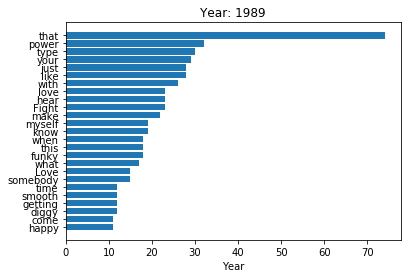

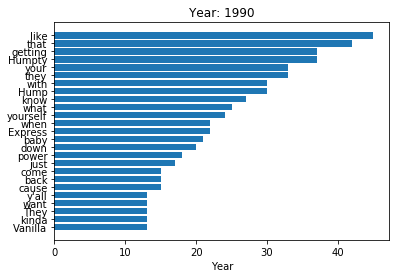

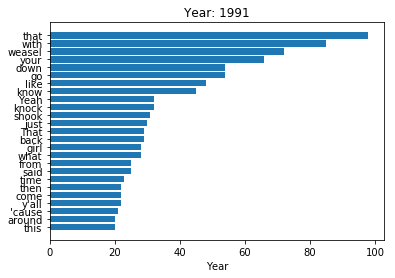

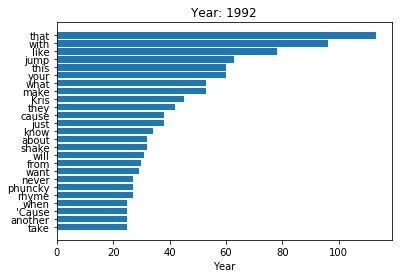

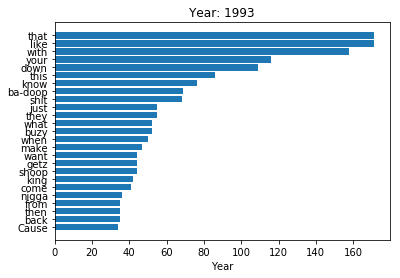

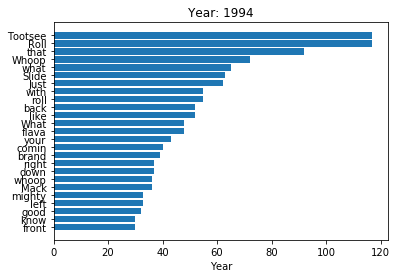

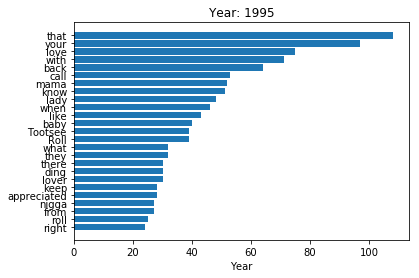

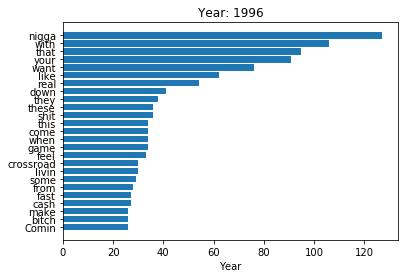

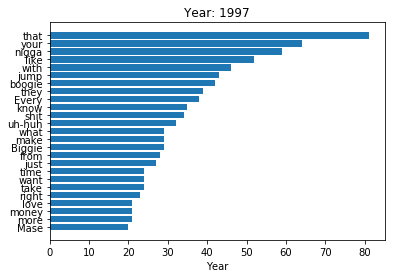

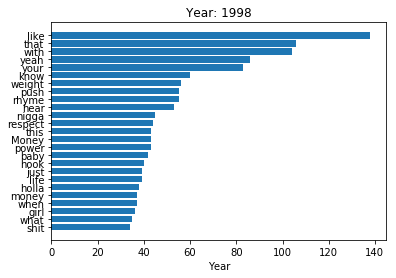

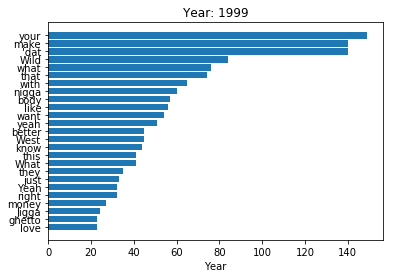

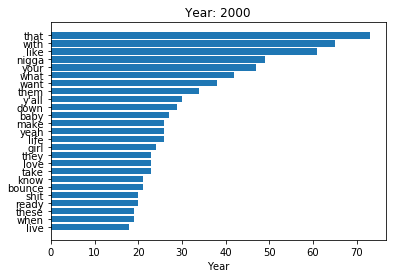

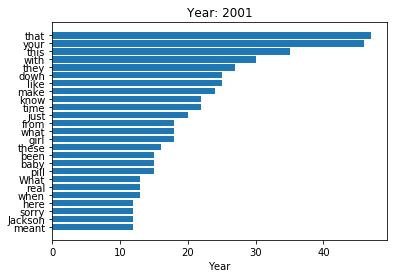

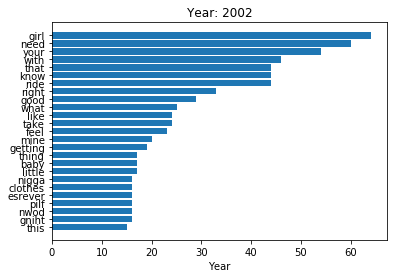

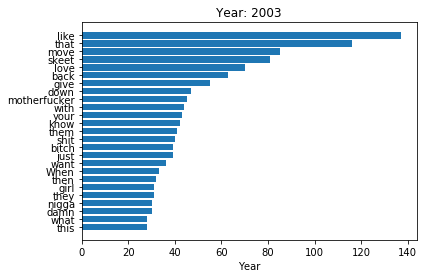

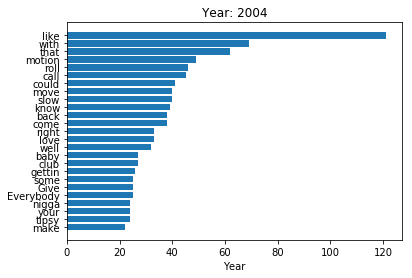

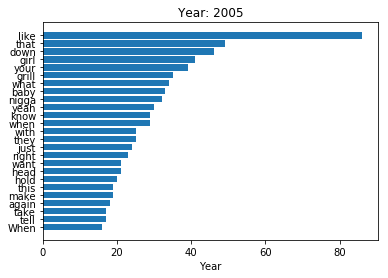

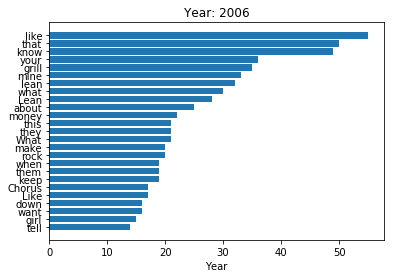

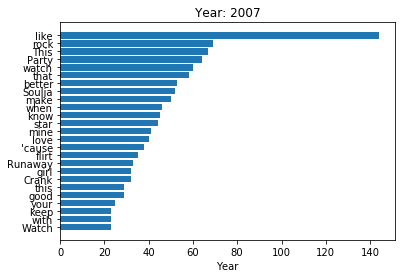

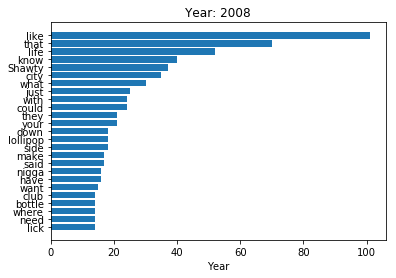

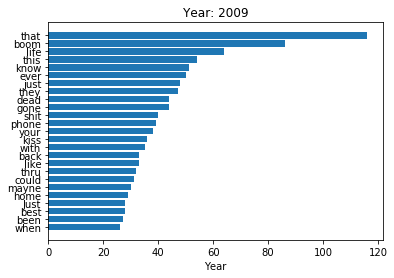

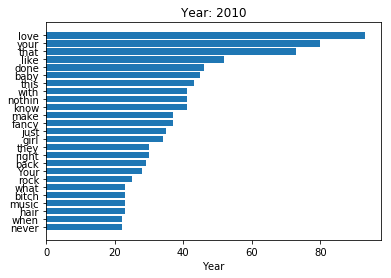

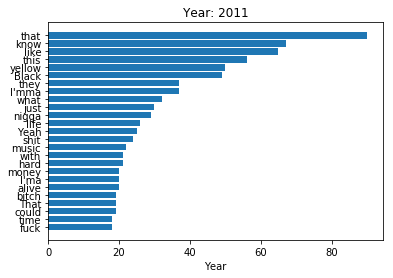

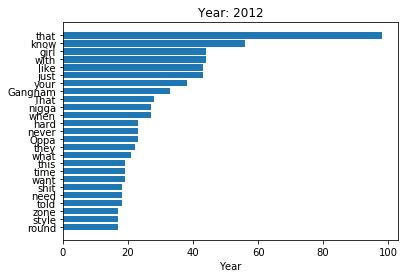

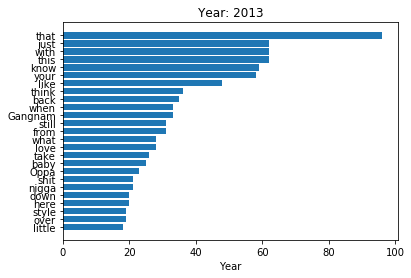

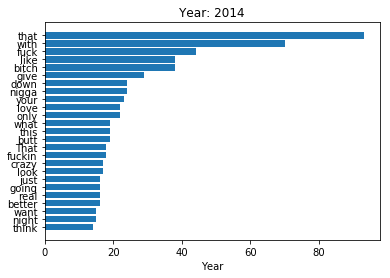

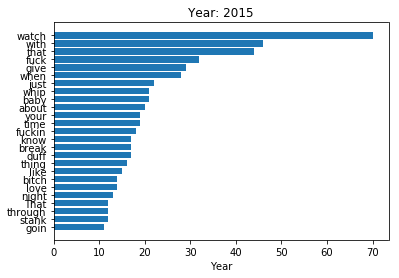

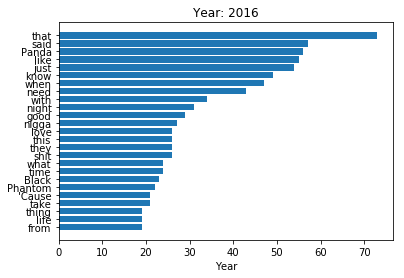

In [18]:
from pylab import *
n = 25
for col in lyrcs:
    t1 = []
    t2 = []
    val = list(lyrcs[col])
    wordlist = nltk.FreqDist(get_top_words(val))
    wordlist.most_common(25)
    for i in range(25):
        t1.append(wordlist.most_common(n)[i][0])
        t2.append(wordlist.most_common(n)[i][1])
    #Plot bar plots of top n words
    bar_locations = np.arange(n)
    plt.barh(-bar_locations, t2)
    yticks(-bar_locations,t1)
    plt.xlabel('Year')
    plt.title('Year: '+col)
    pylab.show()

Although I was able to identify the top 25 words each year, No insight really jumped at me but what I did find was that many derogatory words were in the top 25 words per year so I decided to look at the use of derogatory words from 1990s to 2016. I also noticed this when looking at the words for the respective topics using the lda model. I loaded the top derogatory words from an excel file containing them.

In [19]:
#obtain top derogatory words from excel file
top_derog_words = pd.read_csv('drop_replace.csv', sep=',', usecols = [4])
top_derog_words = [row['Derog1'] for index, row in top_derog_words.iterrows()][0:8]
#obtain usual topics discussed in rap music from excel file
top_topics_rap = pd.read_csv('drop_replace.csv', sep=',', usecols = [5])
top_topics_rap = [row['Derog2'] for index, row in top_topics_rap.iterrows()][0:6]

Once the top derogatory words were loaded from excel, I identified their counts using a natural language toolkit function, summed up the total derogatory words per year and plotted the trend

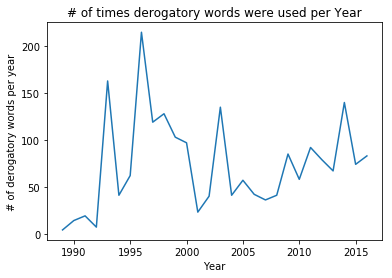

In [20]:
PX=[]
PY=[]
for col in lyrcs:
    PX.append(col)
    val = list(lyrcs[col])
    wordlist = nltk.FreqDist(get_top_words(val))
    k = [wordlist[j] for j in top_derog_words]
    PY.append(sum(k))
    
#Plot trend of derogatory words
plt.plot(PX,PY)
plt.xlabel('Year')
plt.ylabel('# of derogatory words per year')
plt.title('# of times derogatory words were used per Year')
pylab.show()

This was very interesting because I always thought that rap music has been racking up the use of derogatory words from when I really started to listen to music (2005) to present and I was right but it can be seen that in the late 1990s-2000s, the use of derogatory words was significantly higher so that was interesting

I then decided to look at the top things rappers rap about: money, power, and sex and decided to see if the re has been any increase or decrease in usage of those words

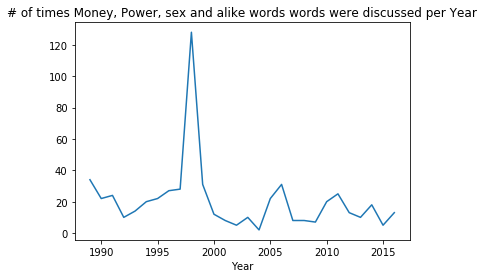

In [21]:
PX=[]
PY=[]
for col in lyrcs:
    PX.append(col)
    val = list(lyrcs[col])
    wordlist = nltk.FreqDist(get_top_words(val))
    i = [wordlist[j] for j in top_topics_rap]
    PY.append(sum(i))

#Plot trend of discussd topics words
plt.plot(PX,PY)
plt.xlabel('Year')
plt.ylabel('')
plt.title('# of times Money, Power, sex and alike words words were discussed per Year')
pylab.show()

This was again interesting because it seems to have remained relatively consistent, apart from 1997, maybe even a decrease. It seems like 1996-1997 seemed like the year when rappers really racked up the use of derogatory words and also talking about money power and sex. The artists that juped at me from this time period was Notorius BIG, 2Pac, Puff daddy but I will need to look further into the songs that caused such a huge spike in derogatory words

Finally, I decided to look into collocations, two words that appear alot, in the lyrics to see if certain phrases were used by rappers. To do so, I wrote a code that looked into the top 15 collocations per year to see if there was a trend. To be in the top collocations, the words had to appear at least 10 times in the lyrics

In [52]:
#Purpose of function:
#identify the top n collcations
#appearing in rap music per year.
#Collocations refers to two words
#that usually appear together
def coll(lyrcs, n):
    for col in lyrcs:
        print("Year: "+col)
        txt = "\n".join(list(lyrcs[col].values))
        shortword = re.compile(r'\W*\b\w{1,2,....,...]}\b')
        txt = shortword.sub('',txt)
        tokens = nltk.wordpunct_tokenize(txt)
        tokens = [lmtizer.lemmatize(tok).lower() for tok in tokens if len(tok)>2]
        finder = BigramCollocationFinder.from_words(tokens)
        finder.apply_freq_filter(11)
        tmp = [" ".join(i) for i in finder.nbest(bigram_measures.pmi, n)]
        print(" , ".join(tmp))
        print("*******************************")

In [53]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
coll(lyrcs, 15)

Year: 1989
getting funky , lemme hear , somebody who , type guy , just myself , power lemme , love somebody , who love , say fight , love for , myself and , guy that , hear you , fight the , the power
*******************************
Year: 1990
kinda hectic , 911 joke , baby vanilla , express yourself , humpty hump , ice baby , power got , getting getting , ice ice , get down , get get , you know , the power , the humpty , got the
*******************************
Year: 1991
mama said , sit back , gonna knock , said knock , way girl , out mama , opp yeah , pop go , with opp , out gonna , that funky , down with , pop pop , weasel pop , knock you
*******************************
Year: 1992
dun dun , live efx , check baby , kris kross , warm kris , some live , phuncky feel , born warm , shake rump , phuncky phuncky , take another , poom poom , wa born , will make , one yes
*******************************
Year: 1993
stab someone , hip hop , snoop doggy , blame licky , detective mon , lane lick

Although it was a bit difficult to discern a trend, it was easy to see that a good portion of the collocations were violent or derogatory words. That seemed to be the trend from the lyrics.

# END
From that lyrics' data, it was interesting to see that the use of derogatory words from when I started listening to music to now has certainly gone up. 
One way I would like to update my project would be to identify the vocabulary level of the lyrics and see if it has gone up or down. I would also like to identify another source for top rap music to further increase my lyrics database to get a more complete picture of the top words and collocations. 

Thanks!

# Export plots for importantfigures and tables

In [260]:
#Exporting table for song and artist name dataframe  
from matplotlib.table import Table
def plotSngArtstTables(df, col_size = 7, row_size = 0.75, picName = 'TBD'):
    fig = 0
    ax = 0
    size = (np.array(df.T.shape[::-1]) + np.array([0, 1])) * np.array([col_size, row_size])
    fig, ax = plt.subplots(figsize = size)
    #ax.set_title('Top Rap Music from 1989 - 2016 Song Titles')
    ax.axis('off') 
    tb = ax.table(cellText=df.T.values, bbox=[0,0,1,1], rowLabels = list(df.T.index), 
                  colLabels=df.T.columns, rowLoc = 'center', colLoc = 'center')
    for cell_ in tb.properties()['child_artists']:
        cell_.set_height(0.2)
        cell_.set_width(0.2)
    col_ = 0
    row_ = 0
    for col_,row_ in tb.get_celld():
        if (col_ > 0 and col_ % 2 == 0 and row_ != -1):
            tb.get_celld()[(col_,row_)].set_color('bisque')
        if col_ == 0:
            tb.get_celld()[(col_,row_)].set_color('lightgrey')
        if row_ == -1:
            tb.get_celld()[(col_,row_)].set_color('lightgrey')
    tb.auto_set_font_size(False)
    tb.set_fontsize(14)
    plt.title('{} from 1989 - 2016'.format(picName), size=100, position =(0.5,1.05))
    plt.show()
    fig.savefig('{}.png'.format(picName.replace(" ","")))

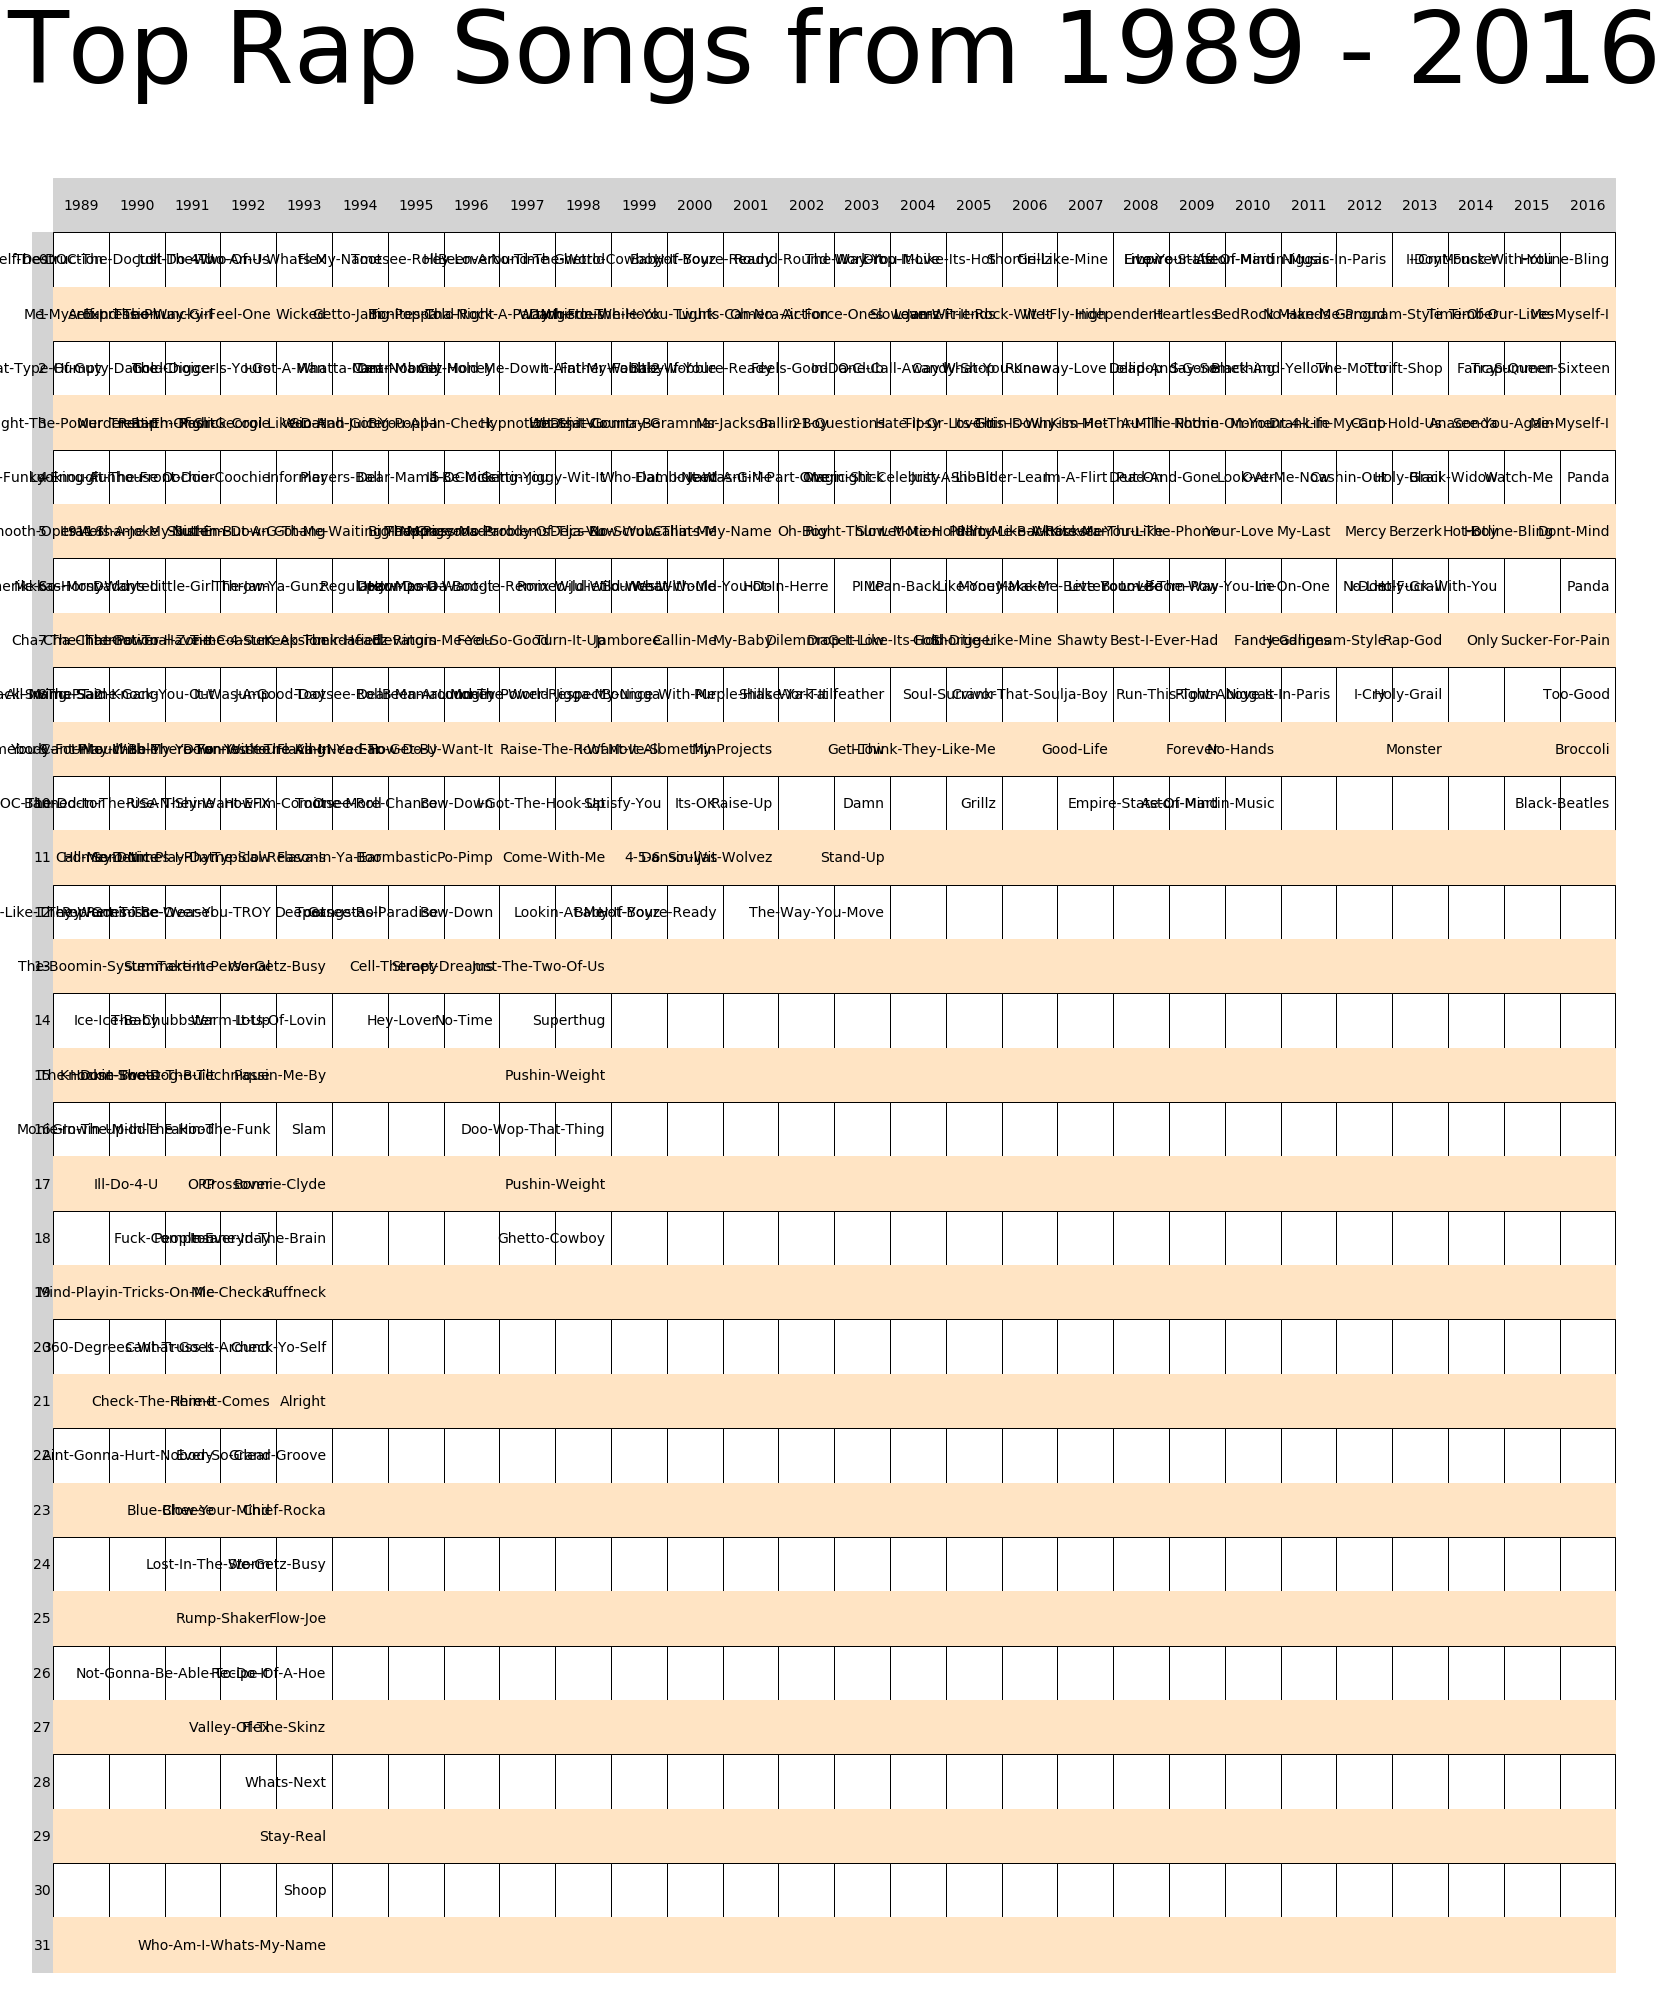

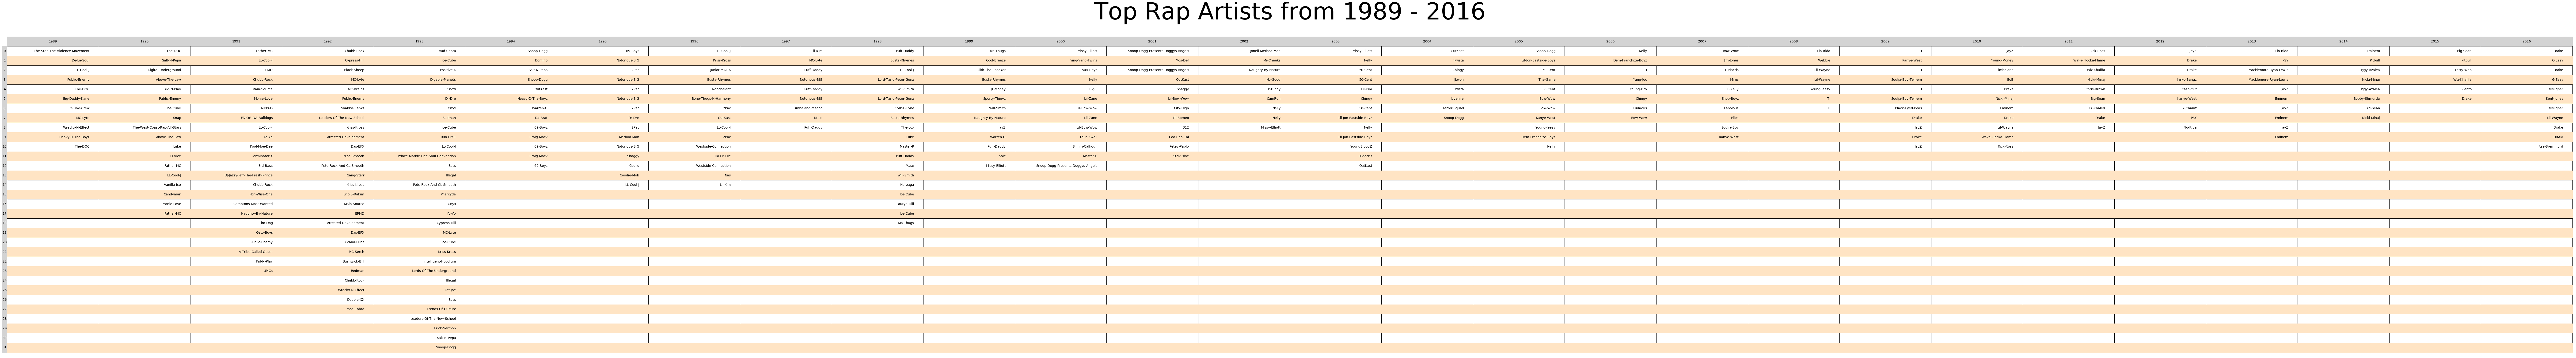

In [265]:
plotSngArtstTables(sng,picName='Top Rap Songs')
plotSngArtstTables(artst,picName='Top Rap Artists')

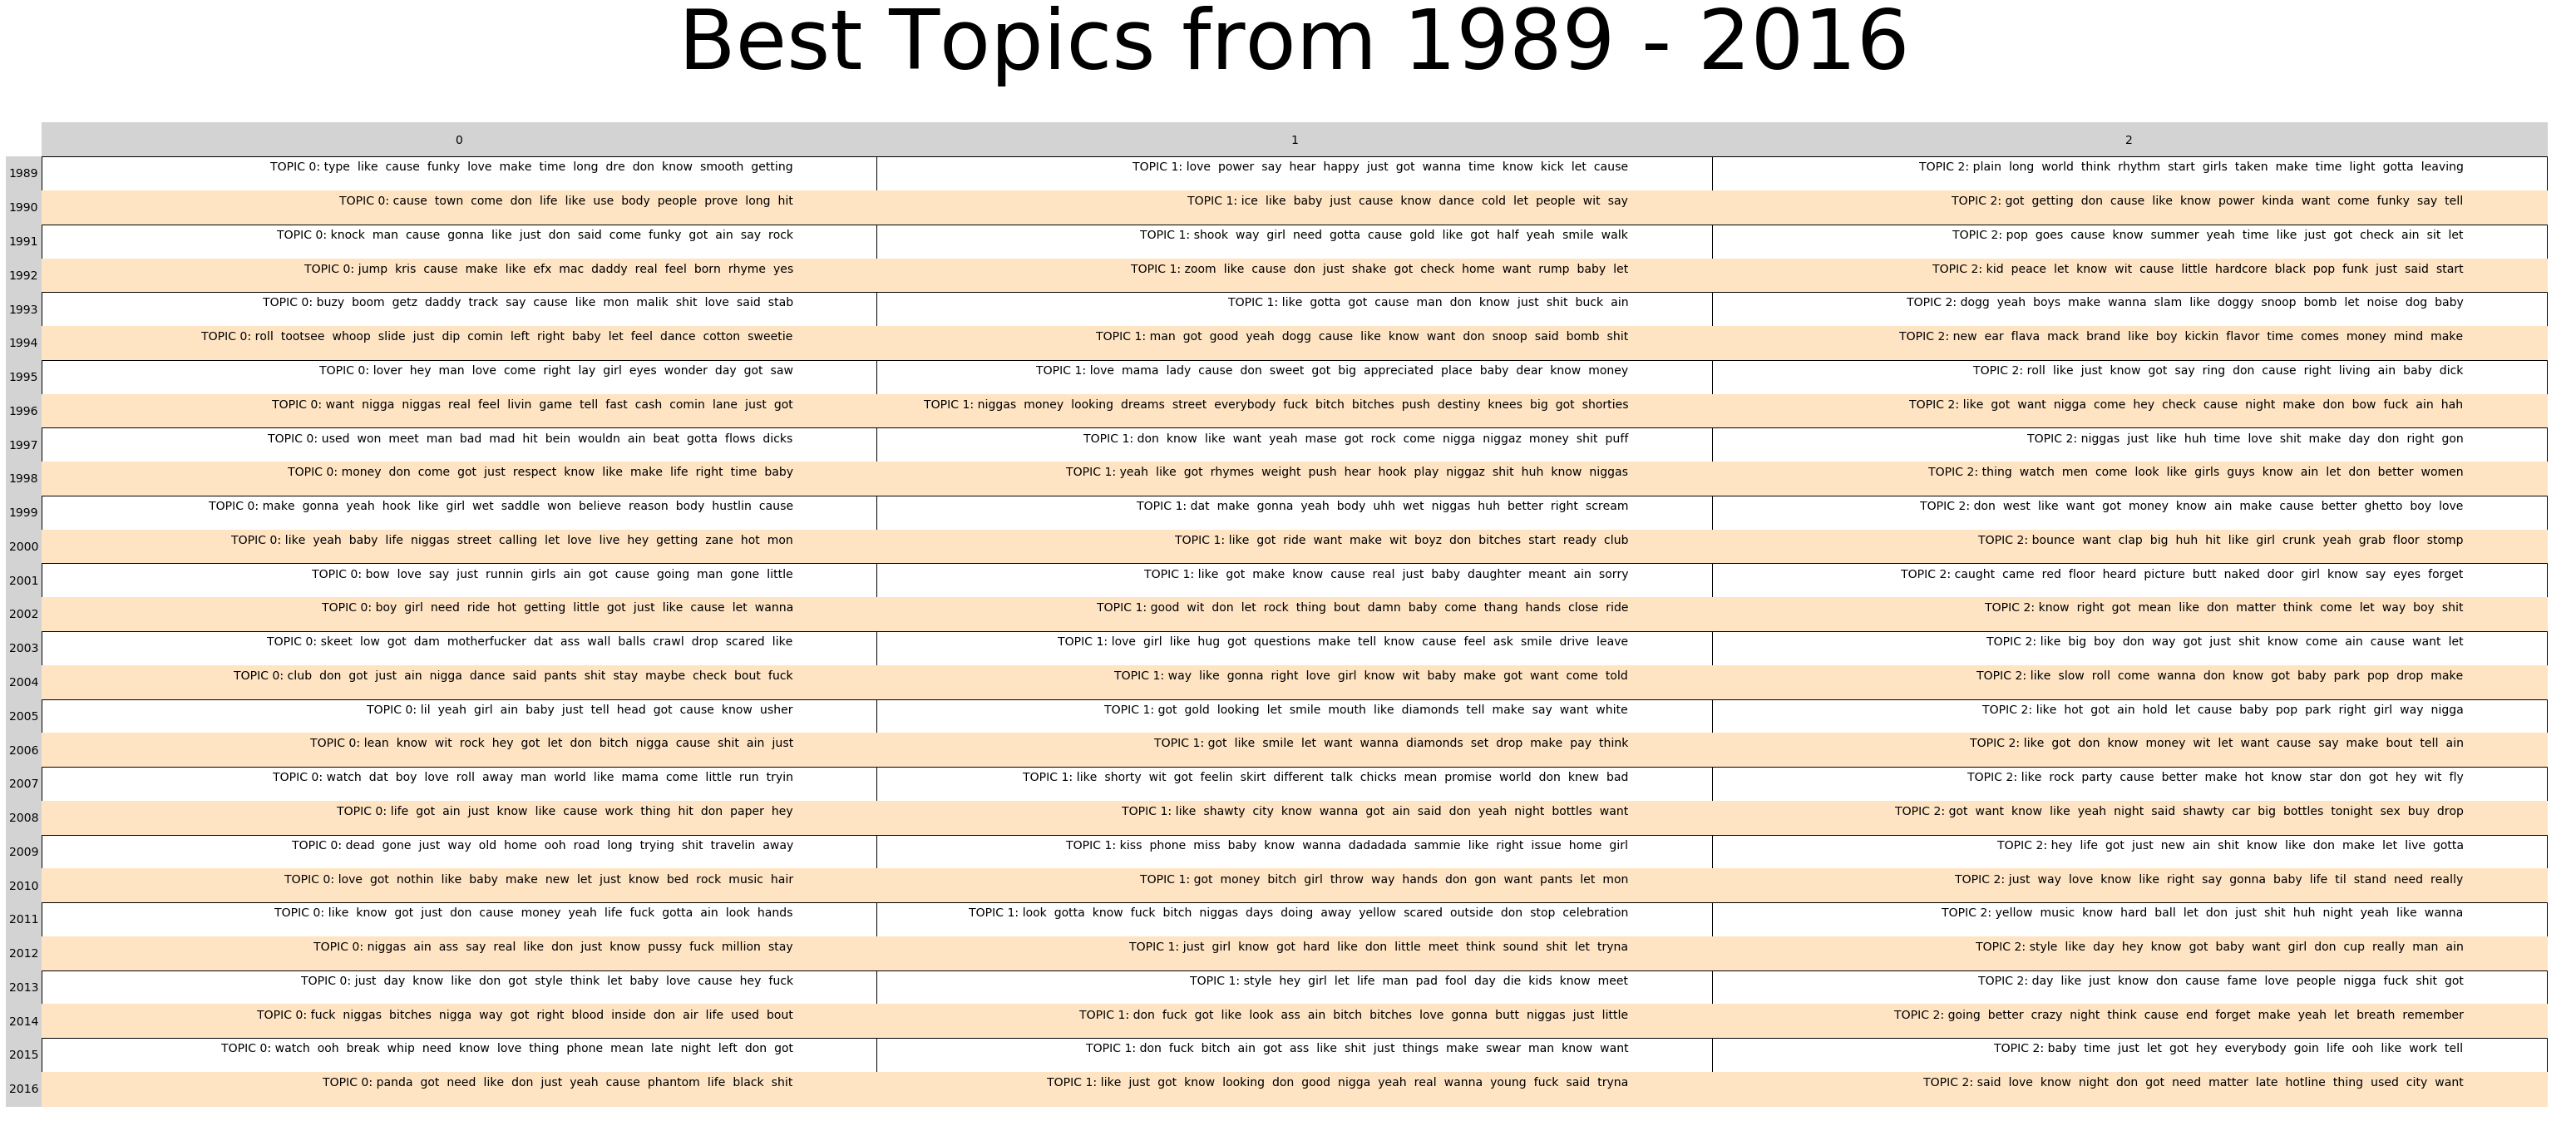

In [262]:
plotSngArtstTables(tp_words,col_size = 18, row_size = 0.75, picName='Best Topics')